# Qiskit 102: Building a Qiskit pattern workflow

## Step 1: Map classical problem to quantum circuits and observables

In [2]:

import rustworkx as rx
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister 
from qiskit.circuit.library import RZZGate, RXGate
from qiskit.quantum_info import SparsePauliOp

In [3]:
def max_cut_hamiltonian (graph: rx. PyGraph) -> SparsePauliOp: 
    terms = [["", [], 0.5* graph.num_edges()]]

    for edge in graph.edge_list():
        terms.append(["ZZ", edge, -0.5])
    
    return SparsePauliOp.from_sparse_list(terms, num_qubits=graph.num_nodes())

In [4]:
def qaoa_circuit (graph: rx.PyGraph, p: int) -> QuantumCircuit: 
    betas = [Parameter(f"b_{i}") for i in range(p)]

    gammas = [Parameter (f"g_{i}") for i in range (p)]

    qubits = QuantumRegister(graph.num_nodes())

    circuit = QuantumCircuit(qubits)
    circuit.h(qubits)

    for beta, gamma in zip (betas, gammas):
        
        for i, j in graph.edge_list():
            circuit.append(RZZGate (gamma), [qubits[i], qubits[j]]) 
        
        for q in qubits:
            circuit.append(RXGate (beta), [q])

    return circuit

In [5]:

n_qubits = 5 
probability = 0.8
p = 1

graph = rx.undirected_gnp_random_graph(num_nodes=n_qubits, probability=probability)

observable = max_cut_hamiltonian(graph)

print(observable)

circuit = qaoa_circuit(graph, p=p)

print(circuit)

SparsePauliOp(['IIIII', 'IIIZZ', 'IIZIZ', 'IZIIZ', 'IZZII', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[ 3.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])
      ┌───┐                                        ┌─────────┐          »
q0_0: ┤ H ├─■─────────■───────────────────■────────┤ Rx(b_0) ├──────────»
      ├───┤ │ZZ(g_0)  │                   │        ├─────────┤          »
q0_1: ┤ H ├─■─────────┼─────────■─────────┼────────┤ Rx(b_0) ├──────────»
      ├───┤           │ZZ(g_0)  │         │        └─────────┘          »
q0_2: ┤ H ├───────────■─────────┼─────────┼──────────■─────────■────────»
      ├───┤                     │         │ZZ(g_0)   │ZZ(g_0)  │        »
q0_3: ┤ H ├─────────────────────┼─────────■──────────■─────────┼────────»
      ├───┤                     │ZZ(g_0)                       │ZZ(g_0) »
q0_4: ┤ H ├─────────────────────■──────────────────────────────■────────»
      └───┘                                                         

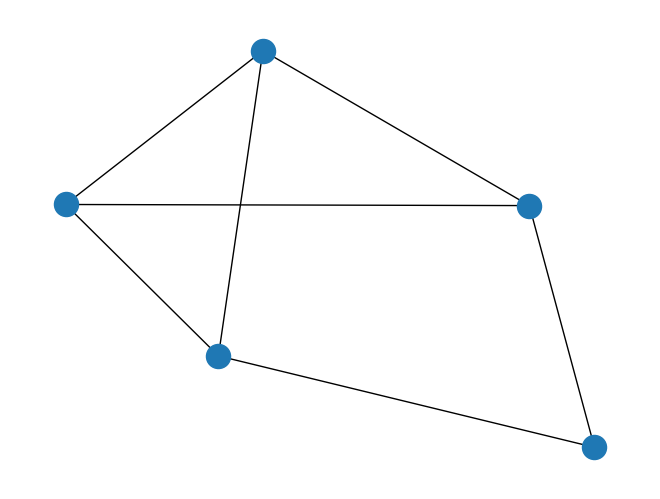

In [6]:
from rustworkx. visualization import mpl_draw

mpl_draw(graph)

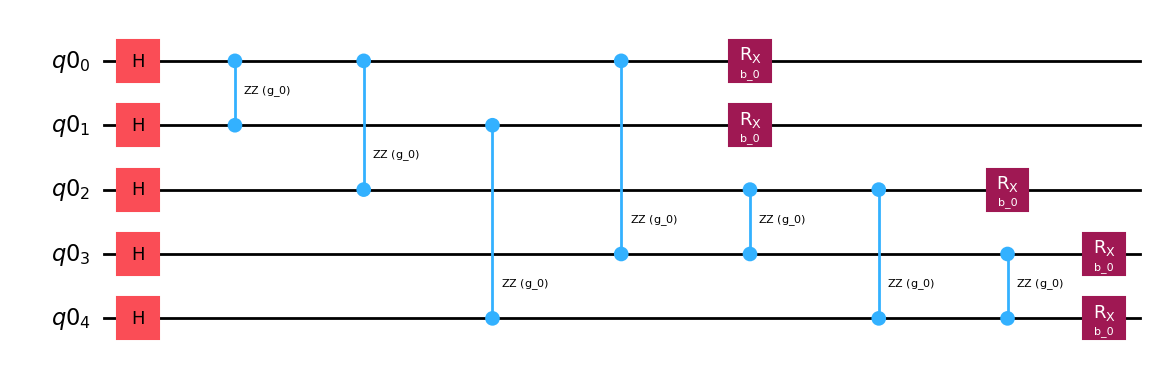

In [7]:
circuit.draw("mpl")

## Step 2: Optimize problem for execution on quantum hardware

In [8]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeSherbrooke()

pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    # initial_layout=[0, 1, 2, 3, 4],
)

isa_circuit = pass_manager.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

In [9]:
observable

SparsePauliOp(['IIIII', 'IIIZZ', 'IIZIZ', 'IZIIZ', 'IZZII', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[ 3.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])

In [10]:
isa_observable

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

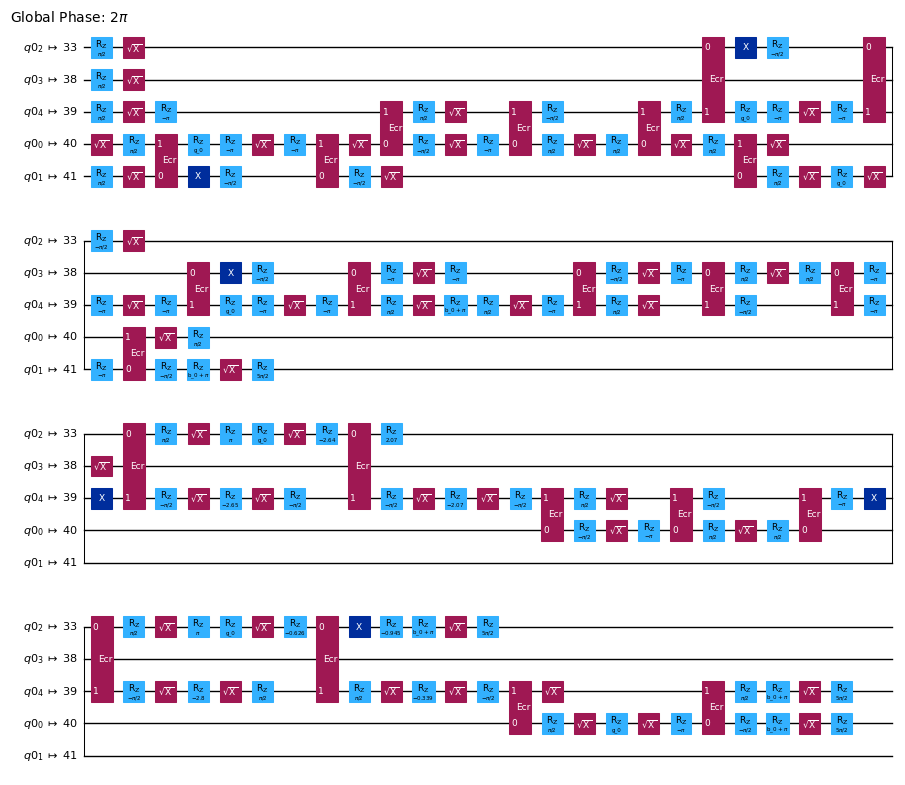

In [11]:
isa_circuit.draw("mpl", idle_wires=False, scale=0.5)

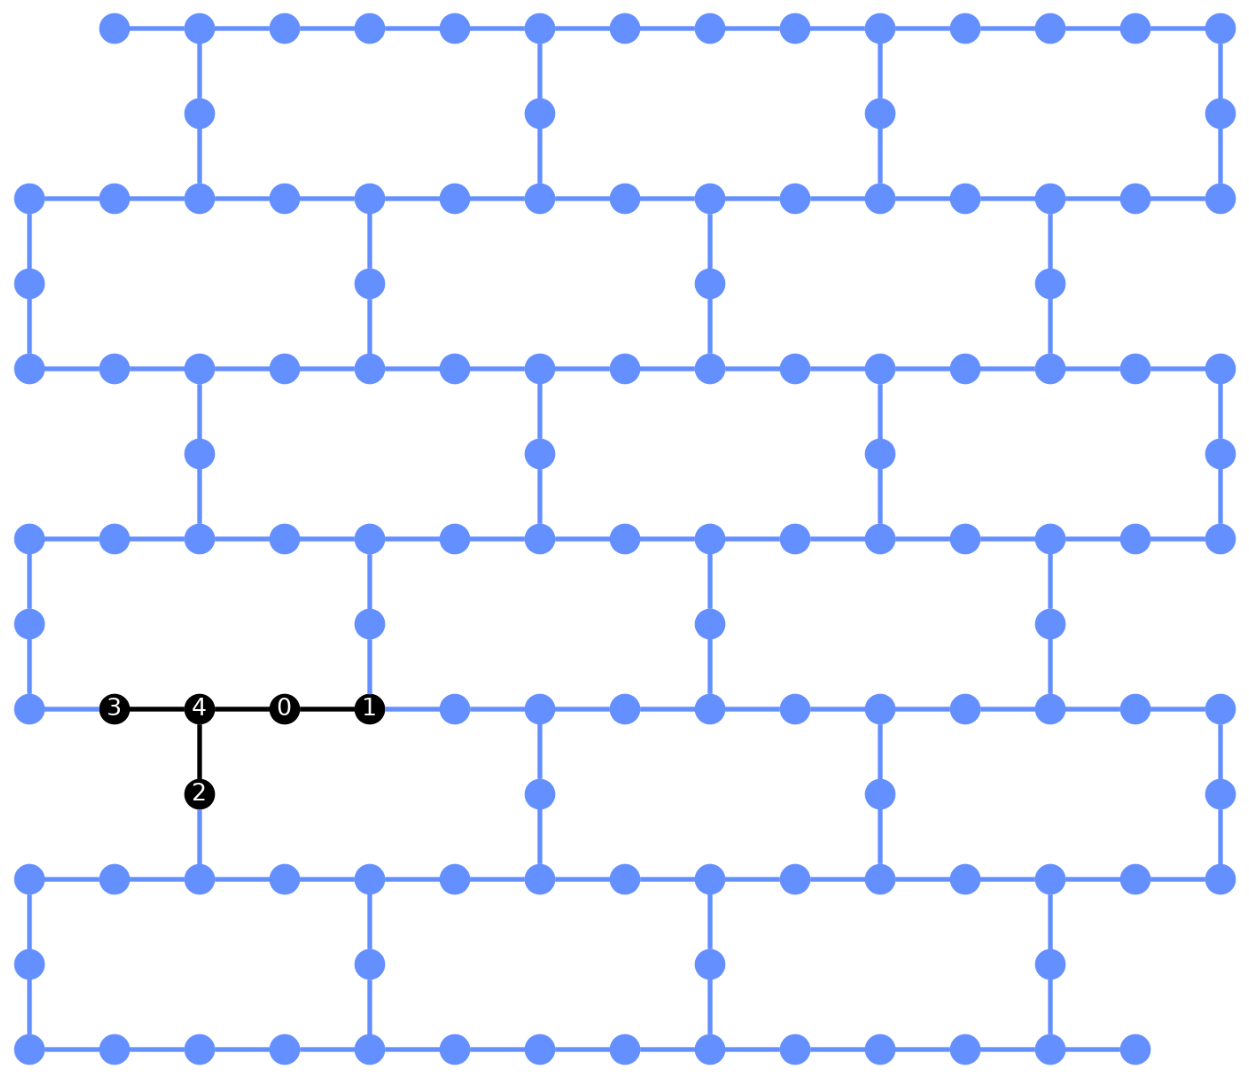

In [12]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(isa_circuit, backend)

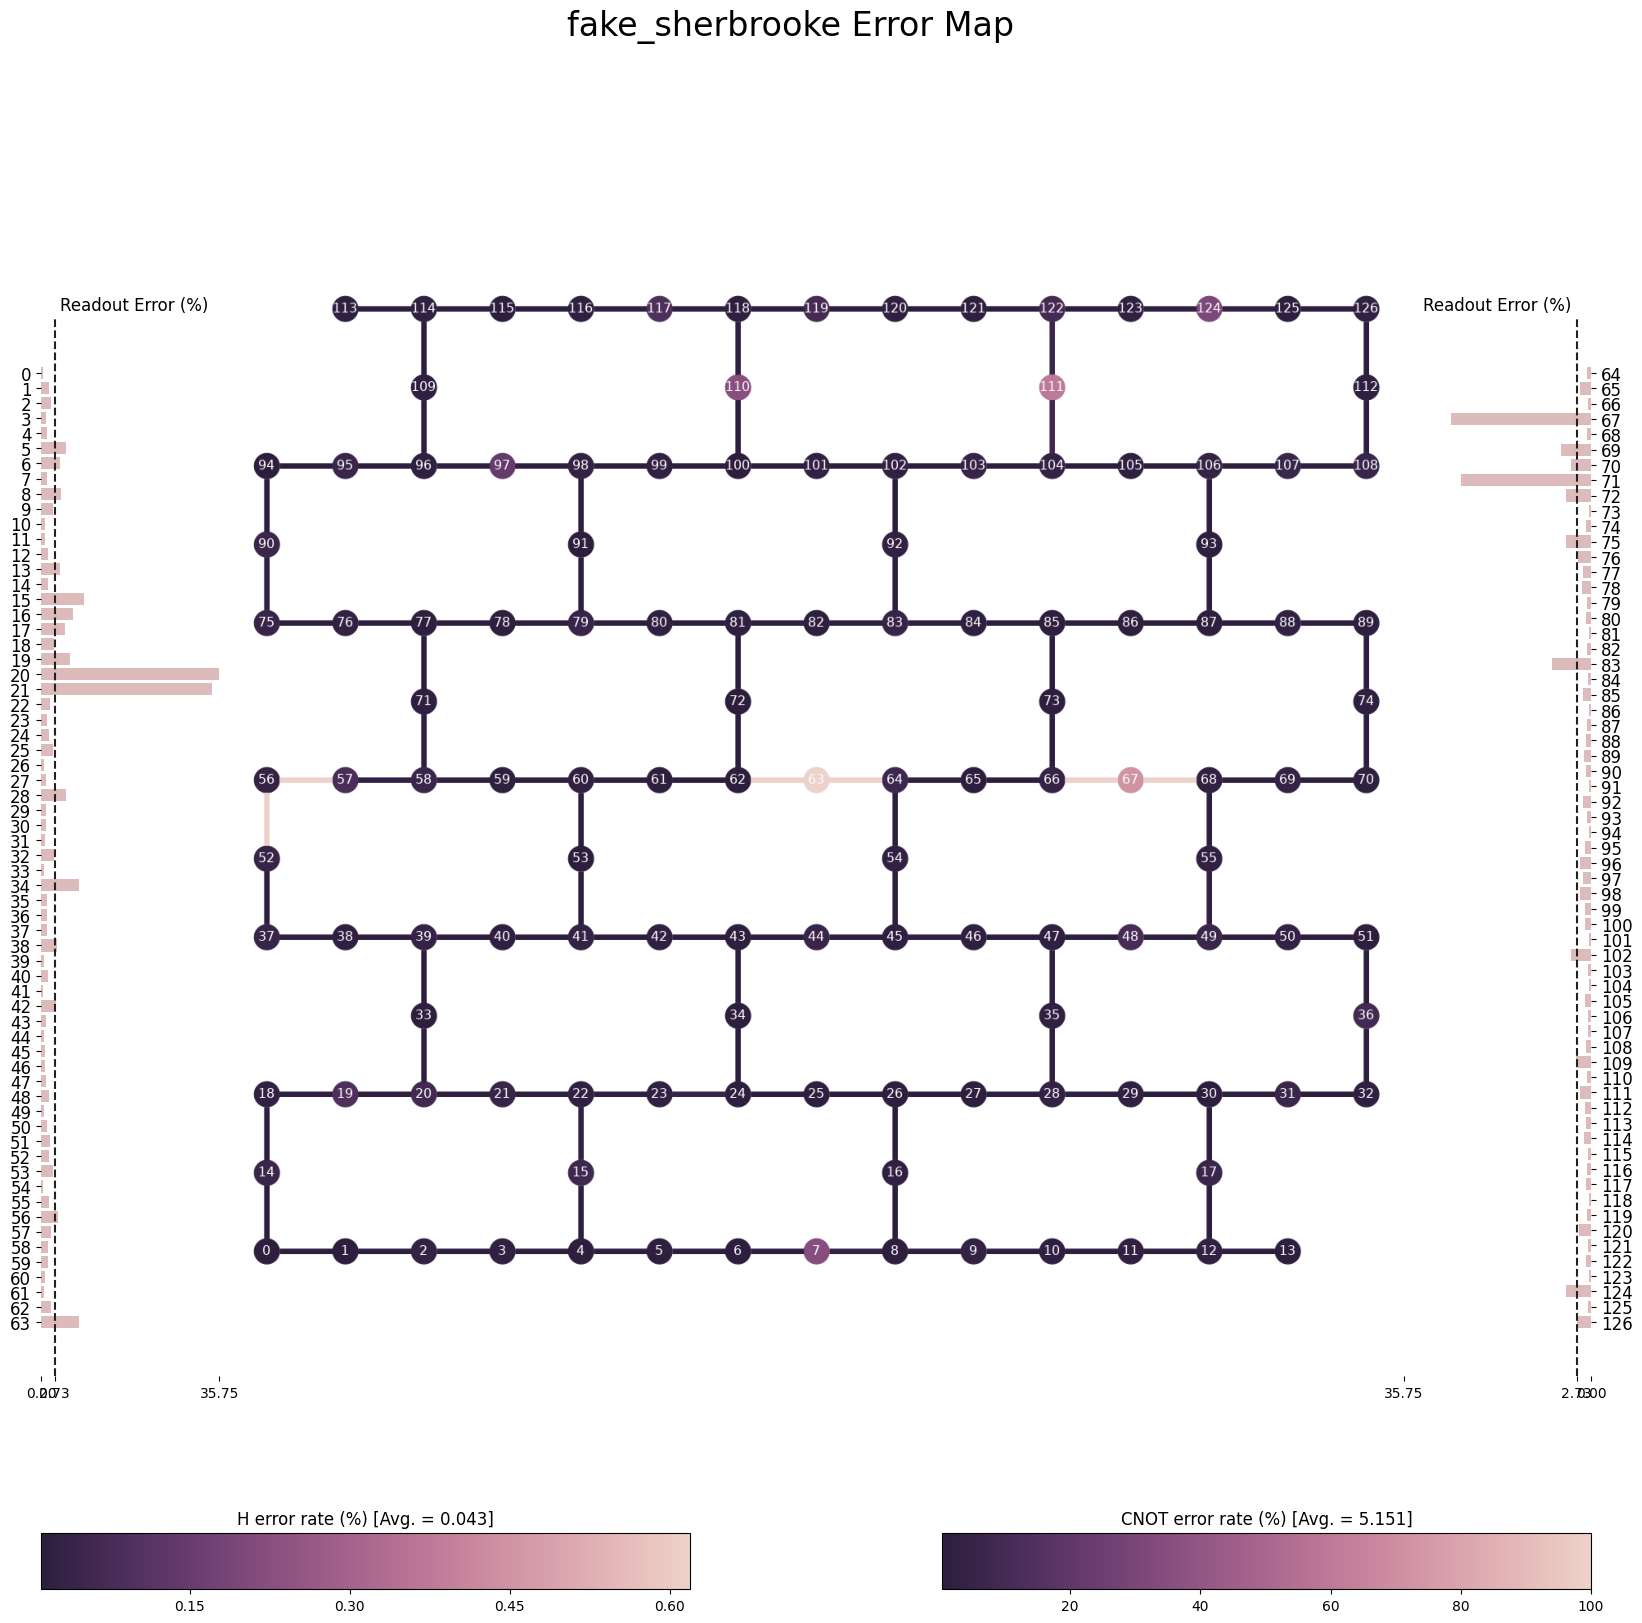

In [13]:
from qiskit.visualization import plot_error_map

plot_error_map(backend, figsize=(20, 20))

## Step 3: Execute circuits using Qiskit Primitives

In [14]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np

rng = np.random.default_rng()
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)


estimator = Estimator(mode=backend)

pub = (isa_circuit, isa_observable, params)
job = estimator.run([pub])

In [15]:
result = job.result()
pub_result = result[0]
expectation_val = float(pub_result.data.evs)
expectation_val

3.026123046875

In [16]:
from qiskit_ibm_runtime import Session
import scipy.optimize


def f(x: np.ndarray, estimator: Estimator) -> float:
    pub = (isa_circuit, isa_observable, x)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    val = -float(pub_result.data.evs)
    print(f"Objective function value: {val}")
    return val


session = Session(backend)
estimator = Estimator(mode = session)
result = scipy.optimize.minimize(
    f, params, args=(estimator,), method="COBYLA", options=dict(maxiter=5)
)

Objective function value: -3.06201171875
Objective function value: -4.1376953125
Objective function value: -3.365966796875
Objective function value: -3.493896484375
Objective function value: -3.583740234375


In [17]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# params = result.x

sampler = Sampler(mode=backend)

circuit_with_meas = circuit.copy()
circuit_with_meas.measure_all()
isa_circuit = pass_manager.run(circuit_with_meas)

pub = (isa_circuit, params)
job = sampler.run([pub])
result = job.result()
pub_result = result[0]
pub_result

SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=5>)), metadata={'shots': 1024, 'circuit_metadata': {}})

## Step 4: Postprocess results into classical format

In [18]:
counts = pub_result.data.meas.get_counts()

bitstring = max(counts, key=lambda x: counts[x])

In [19]:
def cut_size(bitstring: str, graph: rx.PyGraph) -> int:
    return sum(bitstring[-i-1] != bitstring[-j-1] for i, j in graph.edge_list())

cut_size(bitstring, graph)

3

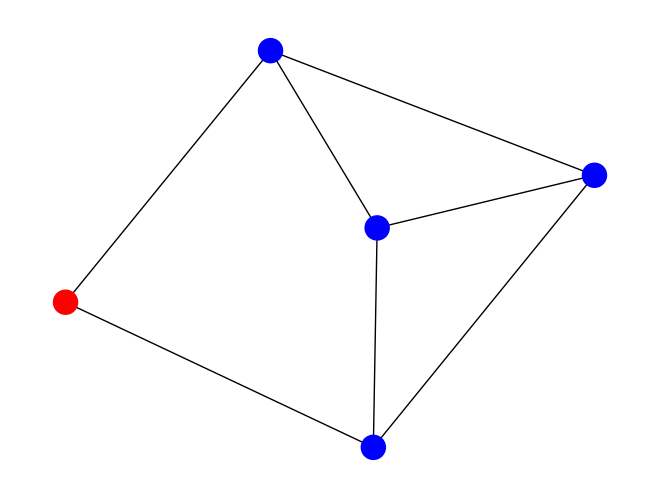

In [20]:
colors = ["red" if b == "0" else "blue" for b in bitstring]

mpl_draw(graph, node_color=colors)